In [15]:
import numpy as np

import os
import tensorflow as tf

from keras.models import Model
from keras.layers import Dense, Input, Add
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal

import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
EXPERIMENT_NAME = 'agent+q_ALOHA(Adam)'

## Fix random seed


In [17]:
def same_seeds(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

same_seeds(48763)

# Protocols


## DQN

In [4]:
class DQN:
    def __init__(self,
                 state_size,
                 n_actions,
                 memory_size=500,
                 replace_target_iter=200,
                 batch_size=32,
                 learning_rate=0.01,
                 gamma=0.9,
                 epsilon=1,
                 epsilon_min=0.01,
                 epsilon_decay=0.995
                 ):
        # hyper-parameters
        self.state_size = state_size
        self.n_actions = n_actions
        self.memory_size = memory_size
        self.replace_target_iter = replace_target_iter
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = np.zeros((self.memory_size, self.state_size * 2 + 2))
        # temporary parameters
        self.learn_step_counter = 0
        self.memory_couter = 0

        # build model
        self.model = self.build_ResNet_model()  # model: evaluate Q value
        self.target_model = self.build_ResNet_model()  # target_mode: target network

    def build_ResNet_model(self):
        inputs = Input(shape=(self.state_size, ))
        h1 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(inputs)  # h1
        h2 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(h1)  # h2

        h3 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(h2)  # h3
        h4 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(h3)  # h4
        add1 = Add()([h4, h2])

        h5 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(add1)  # h5
        h6 = Dense(64, activation="relu",
                   kernel_initializer='glorot_normal')(h5)  # h6
        add2 = Add()([h6, add1])

        outputs = Dense(
            self.n_actions, kernel_initializer='glorot_normal')(add2)
        model = Model(inputs=inputs, outputs=outputs)
        # model.compile(loss="mse", optimizer=RMSprop(
        #     learning_rate=self.learning_rate))
        model.compile(loss="mse", optimizer=Adam(
            learning_rate=self.learning_rate))
        return model

    def choose_action(self, state):
        # Apply epsilon-greedy algorithm
        state = state[np.newaxis, :]
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)

        if np.random.random() < self.epsilon:
            return np.random.randint(0, self.n_actions)

        action_values = self.model.predict(state, verbose=None)
        return np.argmax(action_values)

    def store_transition(self, s, a, r, s_):
        # s_: next_state
        # r: ndarray or int
        if np.isscalar(r):
            r = [r]
        if not hasattr(self, 'memory_couter'):
            self.memory_couter = 0
        transition = np.concatenate((s, [a], r, s_))
        index = self.memory_couter % self.memory_size
        self.memory[index, :] = transition
        self.memory_couter += 1

    def repalce_target_parameters(self):
        weights = self.model.get_weights()
        self.target_model.set_weights(weights)

    def learn(self):
        # check to update target netowrk parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.repalce_target_parameters()  # iterative target model
        self.learn_step_counter += 1

        # sample batch memory from all memory
        if self.memory_couter > self.memory_size:
            sample_index = np.random.choice(
                self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(
                self.memory_couter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        # batch memory row: [s, a, r, s_]
        # number of batch memory: batch size
        state = batch_memory[:, :self.state_size]
        action = batch_memory[:, self.state_size].astype(int)  # float -> int
        reward = batch_memory[:, self.state_size+1]
        next_state = batch_memory[:, -self.state_size:]

        q = self.model.predict(state, verbose=None)  # state
        q_targ = self.target_model.predict(
            next_state, verbose=None)  # next state

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        q[batch_index, action] = reward + self.gamma * np.max(q_targ, axis=1)

        self.model.fit(state, q, self.batch_size, epochs=1, verbose=None)

## TDMA

In [5]:
class TDMA:
    def __init__(self, n_nodes, action_list_len, X):
        # n_actions=2: (wait, transmit)
        # action_list_len and X indicate the parameters of ONE node.
        self.n_nodes = n_nodes
        self.action_list_len = action_list_len
        self.X = X
        self.action_list = self.__create_action_list__()
        self.counter = 0

    def __create_action_list__(self):  # (node, action_list)
        action_list = np.zeros((self.n_nodes, self.action_list_len))
        for i in range(self.n_nodes):
            idx = np.random.randint(
                self.action_list_len, size=self.X)
            action_list[i, idx] = 1
        return action_list

    def tic(self):  # 1D: action of each node
        tdma_action = self.action_list[:, self.counter]
        # tdma_action = np.squeeze(tdma_action)
        self.counter += 1
        if self.counter == self.action_list.shape[1]:
            self.counter = 0
        return tdma_action.astype(np.float32)

    def shuffle(self, _X):  # Change the action pattern.
        self.X = _X
        self.__create_action_list__()

    def reset(self):
        self.action_list = self.__create_action_list__()
        self.counter = 0

## Exponential-backoff ALOHA

In [18]:
class EB_ALOHA:
    def __init__(self, n_nodes, W=2, max_count=2):
        # n_actions=2: (wait, transmit)
        self.n_nodes = n_nodes
        self.max_count = max_count
        self.W = W
        self.actions = np.zeros(self.n_nodes, dtype=np.float32)

        self.count = np.zeros(self.n_nodes, dtype=np.float32)
        self.backoff = np.random.randint(
            0, self.W * 2**self.count, size=self.n_nodes)

    def tic(self):
        self.count = np.minimum(self.count, self.max_count)
        self.backoff -= 1

        filter_arr = self.backoff < 0
        filter_arr = np.arange(self.n_nodes, dtype=np.int32)[filter_arr]
        self.backoff[filter_arr] = np.random.randint(
            0, self.W * 2**self.count)[filter_arr]

        eb_aloha_actions = (self.backoff == 0)
        eb_aloha_actions = eb_aloha_actions.astype(np.float32)
        self.actions = eb_aloha_actions
        return eb_aloha_actions  # return 1 if timeout

    def handle_success(self):
        filter_arr = (self.actions == 1)
        self.count[filter_arr] = np.zeros(self.n_nodes, dtype=np.int32)[filter_arr]
        

    def handle_collision(self):
        filter_arr = (self.actions == 1)
        self.count += filter_arr.astype(np.int32)

    def reset(self):  # Change the action pattern.
        self.count = np.zeros(self.n_nodes)
        self.backoff = np.random.randint(
            0, self.W * 2**self.count, size=self.n_nodes)

## q-ALOHA

In [7]:
class q_ALOHA:
    def __init__(self, n_nodes, q=0.5):
        # n_actions=2: (wait, transmit)
        self.n_nodes = n_nodes
        assert (q <= 1 and q >= 0)
        self.q = q  # probability to send
        self.actions = np.zeros(self.n_nodes, dtype=np.float32)

    def tic(self):
        # return 1 with prob. q
        return np.random.choice(2, self.n_nodes, p=[1-self.q, self.q])

    def reset(self):  # Change the action pattern.
        pass

# Environment

In [8]:
class ENVIRONMENT:
    def __init__(self, config):
        self.n_TDMA = config.n_TDMA
        self.n_EB_ALOHA = config. n_EB_ALOHA
        self.n_q_ALOHA = config.n_q_ALOHA
        
        self.TDMA_nodes = TDMA(config.n_TDMA, config.action_list_len, config.X)
        self.EB_ALOHA_nodes = EB_ALOHA(
            config.n_EB_ALOHA, config.W, config.max_count)
        self.q_ALOHA_nodes = q_ALOHA(config.n_q_ALOHA, config.q)
        
        self.state_size = config.state_size

    def reset(self):
        self.TDMA_nodes.reset()
        self.EB_ALOHA_nodes.reset()
        self.q_ALOHA_nodes.reset()
        
        init_state = np.zeros(self.state_size)
        return init_state

    def step(self, action):
        agent_reward = 0
        tdma_reward = np.zeros(self.n_TDMA)
        eb_aloha_reward = np.zeros(self.n_EB_ALOHA)
        q_aloha_reward = np.zeros(self.n_q_ALOHA)

        tdma_actions = np.zeros(self.n_TDMA, dtype=np.float32)
        eb_aloha_actions = np.zeros(self.n_EB_ALOHA, dtype=np.float32)
        q_aloha_actions = np.zeros(self.n_q_ALOHA, dtype=np.float32)

        reward = 0
        observation_ = 0

        if self.n_TDMA > 0:
            tdma_actions = self.TDMA_nodes.tic()
        if self.n_EB_ALOHA > 0:
            eb_aloha_actions = self.EB_ALOHA_nodes.tic()
        if self.n_q_ALOHA > 0:
            q_aloha_actions = self.q_ALOHA_nodes.tic()

        if action == 1:
            if np.sum(tdma_actions)+np.sum(eb_aloha_actions)+np.sum(q_aloha_actions) > 0:  # collision
                observation_ = 'F'  # tx, failed
                self.EB_ALOHA_nodes.handle_collision()
            else:  # agent success
                reward = 1.0
                agent_reward = 1.0
                observation_ = 'S'  # tx, success
        else:
            other_tx = np.sum(tdma_actions) + \
                np.sum(eb_aloha_actions)+np.sum(q_aloha_actions)

            if other_tx == 0:  # idle
                observation_ = 'I'
            elif other_tx == 1:  # media busy
                reward = 1.0
                tdma_reward = tdma_actions
                eb_aloha_reward = eb_aloha_actions
                q_aloha_reward = q_aloha_actions
                observation_ = 'B'
                self.EB_ALOHA_nodes.handle_success()
            else:  # some nodes collide
                reward = 1.0
                observation_ = 'B'
                self.EB_ALOHA_nodes.handle_collision()

        return observation_, reward, agent_reward, tdma_reward, eb_aloha_reward, q_aloha_reward

# Run DQN


## Configurations

In [9]:
class Config:
    def __init__(self):
        # n_DQN = 1
        self.n_TDMA = 0
        self.n_EB_ALOHA = 0
        self.n_q_ALOHA = 1

        self.max_iter = 4000 # simulation iterations
        self.N = 1000 # plot with avg of N iters

        # Agent (DLMA)
        self.M = 20  # state length
        self.E = 500  # memory size
        self.F = 20  # target network update frequency
        self.B = 32  # mini-batch size
        # state = cat(s[8:], [action, observation, agent_reward, sum of others' reward])
        self.state_size = int(8*self.M)

        # TDMA
        self.action_list_len = 10  # length of one period
        self.X = 3  # number of slot used in one perios

        # Exponential-backoff ALOHA
        # wnd = randint(0, W*2^count)
        self.W = 2   # minimum window size
        self.max_count = 2  # maximum backoff count
        
        # q-ALOHA
        self.q = .3

In [10]:
config = Config()

env = ENVIRONMENT(config=config)

dqn_agent = DQN(env.state_size,
                n_actions=2,
                memory_size=config.E,
                replace_target_iter=config.F,
                batch_size=config.B,
                learning_rate=0.01,
                gamma=0.9,
                epsilon=0.5,
                epsilon_min=0.005,
                epsilon_decay=0.995,
                )

In [11]:
def return_action(action, n_actions=2):
    one_hot_vector = [0] * n_actions
    one_hot_vector[action] = 1
    return one_hot_vector


def return_observation(o):
    if o == 'S':
        return [1, 0, 0, 0]
    elif o == 'F':
        return [0, 1, 0, 0]
    elif o == 'B':
        return [0, 0, 1, 0]
    elif o == 'I':
        return [0, 0, 0, 1]


def main(config):
    agent_reward_list = []
    tdma_reward_list = []
    eb_aloha_reward_list = []
    q_aloha_reward_list = []
    state = env.reset()

    M, E, F, B, X, W, q = config.M, config.E, config.F, config.B, config.X, config.W, config.q
    n_TDMA, n_EB_ALOHA, n_q_ALOHA = config.n_TDMA, config.n_EB_ALOHA, config.n_q_ALOHA
    max_iter = config.max_iter

    for i in tqdm(range(config.max_iter)):
        agent_action = dqn_agent.choose_action(state)
        observation_, reward, agent_reward, tdma_reward, eb_aloha_reward, q_aloha_reward = env.step(
            agent_action)

        agent_reward_list.append(agent_reward)
        tdma_reward_list.append(tdma_reward)
        eb_aloha_reward_list.append(eb_aloha_reward)
        q_aloha_reward_list.append(q_aloha_reward)

        # state = (action_t, observation_t)
        next_state = np.concatenate((state[8:], np.array(return_action(
            agent_action) + return_observation(observation_) + [agent_reward, np.sum(tdma_reward)+np.sum(eb_aloha_reward)+np.sum(q_aloha_reward)], dtype=np.float32)))
        dqn_agent.store_transition(state, agent_action, reward, next_state)
        if i > 100:
            dqn_agent.learn()    # internally iterates default (prediction) model
        state = next_state

    agent_arr = np.array(agent_reward_list, dtype=np.float32)
    tdma_arr = np.array(tdma_reward_list, dtype=np.float32)
    eb_aloha_arr = np.array(eb_aloha_reward_list, dtype=np.float32)
    q_aloha_arr = np.array(q_aloha_reward_list, dtype=np.float32)

    if not os.path.isdir('./rewards'):
        os.mkdir('./rewards')
    file_path = f'rewards/{EXPERIMENT_NAME}_rewards_t{n_TDMA}_ea{n_EB_ALOHA}_qa{n_q_ALOHA}_M{M}_E{E:.0E}_F{F}_B{B}_X{X}_W{W}_q{q}_{max_iter:.0E}.npz'
    np.savez(file_path, agent=agent_arr, tdma=tdma_arr,
             eb_aloha=eb_aloha_arr, q_aloha=q_aloha_arr)

    return file_path

In [12]:
file_path = main(config=config)

100%|██████████| 4000/4000 [14:33<00:00,  4.58it/s]


# Average_throughput


In [13]:
def plot_avg_throughput(file):
    max_iter = config.max_iter
    N = config.N

    # load reward
    reward = np.load(file)

    avg_throughput_agent = np.zeros((1, max_iter))
    avg_throughput_tdma = np.zeros((1, max_iter))
    avg_throughput_eb_aloha = np.zeros((1, max_iter))
    avg_throughput_q_aloha = np.zeros((1, max_iter))

    agent_temp_sum = 0
    tdma_temp_sum = 0
    eb_aloha_temp_sum = 0
    q_aloha_temp_sum = 0

    # print(reward['tdma'].size, reward['eb_aloha'].size, reward['q_aloha'].size)
    agent_reward = reward['agent']
    tdma_reward = np.sum(
        reward['tdma'], axis=1) if reward['tdma'].size != 0 else np.zeros(max_iter)
    eb_aloha_reward = np.sum(
        reward['eb_aloha'], axis=1) if reward['eb_aloha'].size != 0 else np.zeros(max_iter)
    q_aloha_reward = np.sum(
        reward['q_aloha'], axis=1) if reward['q_aloha'].size != 0 else np.zeros(max_iter)

    for i in range(0, max_iter):
        if i < N:
            agent_temp_sum += agent_reward[i]
            avg_throughput_agent[0][i] = agent_temp_sum / (i+1)
            tdma_temp_sum += tdma_reward[i]
            avg_throughput_tdma[0][i] = tdma_temp_sum / (i+1)
            eb_aloha_temp_sum += eb_aloha_reward[i]
            avg_throughput_eb_aloha[0][i] = eb_aloha_temp_sum / (i+1)
            q_aloha_temp_sum += q_aloha_reward[i]
            avg_throughput_q_aloha[0][i] = q_aloha_temp_sum / (i+1)
        else:
            agent_temp_sum += agent_reward[i] - agent_reward[i-N]
            avg_throughput_agent[0][i] = agent_temp_sum / N
            tdma_temp_sum += tdma_reward[i] - tdma_reward[i-N]
            avg_throughput_tdma[0][i] = tdma_temp_sum / N
            eb_aloha_temp_sum += eb_aloha_reward[i] - eb_aloha_reward[i-N]
            avg_throughput_eb_aloha[0][i] = eb_aloha_temp_sum / N
            q_aloha_temp_sum += q_aloha_reward[i] - q_aloha_reward[i-N]
            avg_throughput_q_aloha[0][i] = q_aloha_temp_sum / N

    # Total throughput
    avg_throughput_total = avg_throughput_agent + avg_throughput_tdma + \
        avg_throughput_eb_aloha + avg_throughput_q_aloha

    plt.xlim((0, max_iter))
    plt.ylim((-0.05, 1))

    legend_list = []

    agent_line, = plt.plot(
        avg_throughput_agent[0], color='c', lw=1, label='agent')
    legend_list.append(agent_line)

    if config.n_TDMA > 0:
        tdma_line, = plt.plot(
            avg_throughput_tdma[0], color='m', lw=1, label='tdma')
        legend_list.append(tdma_line)

    if config.n_EB_ALOHA > 0:
        eb_aloha_line, = plt.plot(
            avg_throughput_eb_aloha[0], color='y', lw=1, label='em-aloha')
        legend_list.append(eb_aloha_line)

    if config.n_q_ALOHA > 0:
        q_aloha_line, = plt.plot(
            avg_throughput_q_aloha[0], color='g', lw=1, label='q-aloha')
        legend_list.append(q_aloha_line)

    total_line, = plt.plot(
        avg_throughput_total[0], color='r', lw=1.5, label='total')
    legend_list.append(total_line)

    plt.grid()
    plt.legend(handles=legend_list, loc='best')
    plt.xlabel("iteration")
    plt.ylabel("average throughput")

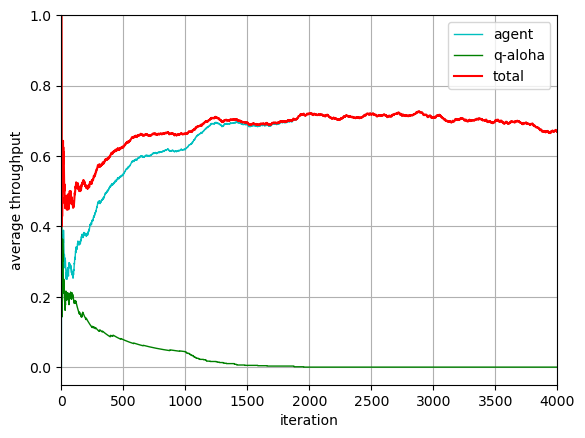

In [14]:
fig1 = plt.figure()
plot_avg_throughput(file_path)

plt.show()